In [1]:
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
feature_names = cancer.feature_names

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Feature importance

Feature importance measures how much each input feature contributes to a model's predictions.

| Model Type                     | Method                                |
|-------------------------------|----------------------------------------|
| Decision Tree / Random Forest | Use `.feature_importances_`  |
| Logistic Regression / Linear SVM | Use absolute value of `coef_`             |
| Naive Bayes               | No direct method; analyze `feature_log_prob_` for |
| Model-agnostic            | Permutation importance     |

**Two best approaches:**
- **Random Forest**: Reliable and fast, but can be biased toward high-cardinality features
- **Permutation importance**: Slower but more faithful to actual model behavior


#### Feature importance calculated by Decision Tree / Random Forest


Tree-based models like **Decision Trees** and **Random Forests** provide built-in feature importance scores (via `.feature_importances_`) based on **impurity reduction** — typically using Gini impurity or Entropy.

**These importance scores can be unstable. Why?**

- **High variance**: Decision Trees are greedy and sensitive to small changes in data. Slight variations in training data can lead to very different splits and thus different importance rankings.
- **Bias toward high cardinality features**: Features with many unique values (e.g., IDs or continuous variables) are more likely to appear useful during splitting, even if they’re not truly predictive.
- **Overfitting**: Feature importance is computed during training. If the model overfits, the importance scores reflect what helped memorize the training data — not what generalizes well.
- **Correlated features**: When features are correlated, importance is split arbitrarily. One may be assigned most of the credit while the other appears unimportant, even though both carry similar information.

**Recommendations**

- Repeat model training multiple times (with different random seeds or data splits) and **average the feature importances** — this helps identify features that are consistently important and reduces the effect of random variability in the model training process.
- Additionally use `permutation_importance` to assess importance.

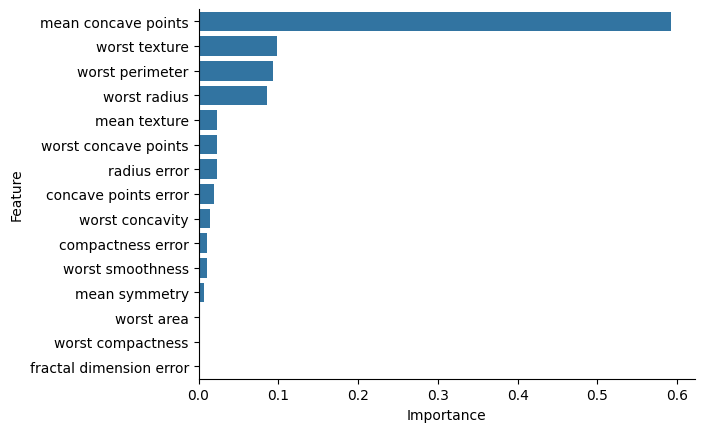

In [3]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='entropy', random_state=0)
dt.fit(X_train, y_train)

# Get feature importances
dt_importances = dt.feature_importances_

dt_df = pd.DataFrame({'Feature': feature_names, 'Importance': dt_importances}).sort_values(by='Importance', ascending=False)

sns.barplot(data=dt_df.head(15), x='Importance', y='Feature')
sns.despine()

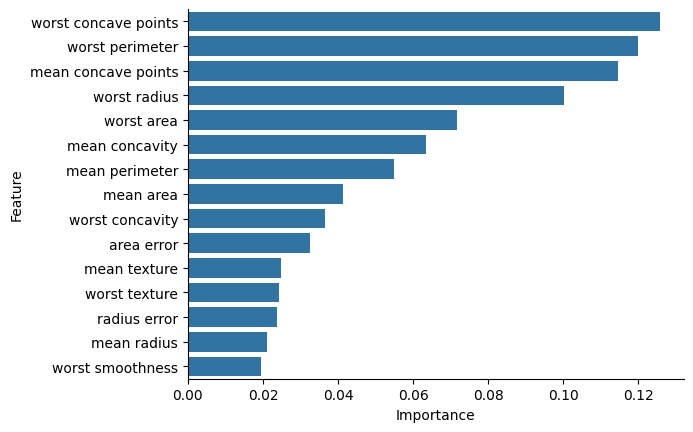

In [4]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(criterion='entropy', random_state=0)
rf.fit(X_train, y_train)

# Get feature importances
rf_importances = rf.feature_importances_

rf_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances}).sort_values(by='Importance', ascending=False)

sns.barplot(data=rf_df.head(15), x='Importance', y='Feature')
sns.despine()

#### Feature importance calculated by Logistic Regression / Linear SVM

Linear models like **Logistic Regression** and **Linear SVM** (`kernel='linear'`) provide feature importance through their **model coefficients** (accessible via `.coef_`). These coefficients define the direction of the decision boundary (or separating hyperplane) and represent the influence of each feature on the prediction.

**These importance scores can be misleading. Why?**

- **Scale sensitivity**: Coefficients depend on feature scale. A large coefficient may simply reflect a small-scale feature. Feature scaling (e.g., standardization) is essential before interpreting.
- **Correlated features**: When features are correlated, coefficients can become unstable or cancel each other out, leading to misleading interpretations.
- **Multicollinearity**: High correlation between features can inflate the variance in coefficient estimates, making them sensitive to small data changes.
- **Margin or log-odds focused learning**: These models focus on separating classes (e.g., maximizing margin in SVM or estimating log-odds in Logistic Regression), which may not reflect global feature importance across the entire dataset.

**Recommendations**

- Standardize features before interpreting coefficients — this makes them comparable and reflects relative influence properly.
- Repeat model training multiple times (with different random seeds or data splits) and **average the standardized coefficients** — this helps identify features that are consistently influential.
- Additionally use `permutation_importance` to assess importance.

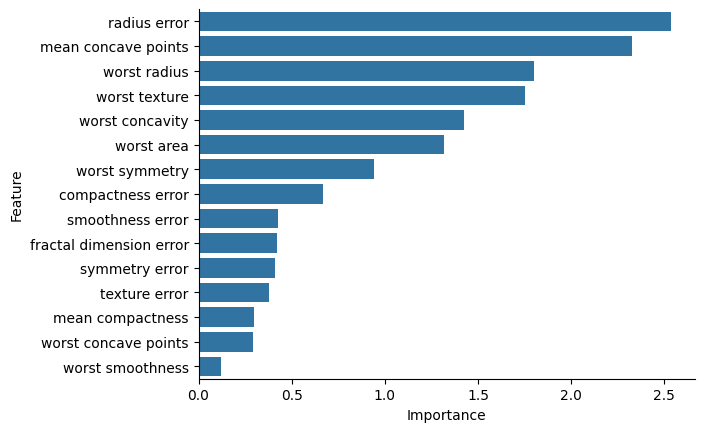

In [5]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=10000, solver='saga', penalty='l1')
log_reg.fit(X_train_scaled, y_train)

log_importance = abs(log_reg.coef_[0])

log_df = pd.DataFrame({'Feature': feature_names, 'Importance': log_importance}).sort_values(by='Importance', ascending=False)

sns.barplot(data=log_df.head(15), x='Importance', y='Feature')
sns.despine()

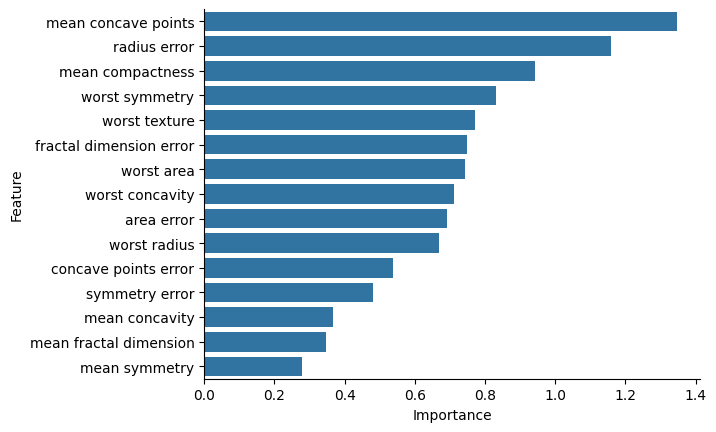

In [6]:
from sklearn.svm import LinearSVC

svm = LinearSVC(max_iter=10000)
svm.fit(X_train_scaled, y_train)

svm_importance = abs(svm.coef_[0])

svm_df = pd.DataFrame({'Feature': feature_names, 'Importance': svm_importance}).sort_values(by='Importance', ascending=False)

sns.barplot(data=svm_df.head(15), x='Importance', y='Feature')
sns.despine()

#### Feature importance calculated by Naive Bayes

**Multinomial/Bernoulli Naive Bayes** provide access to class-conditional feature probabilities via the attribute `feature_log_prob_`. You can compute feature importance by measuring the difference in log-probabilities between classes. The formula is:

$$
\text{Importance}_j = \left| \log P(x_j \mid y = 1) - \log P(x_j \mid y = 0) \right|,
$$

where:
- $ P(x_j \mid y = 1) $ is the probability of feature $ j $ given class 1
- $ P(x_j \mid y = 0) $ is the probability of feature $ j $ given class 0


```python
log_prob = nb.feature_log_prob_
importance = np.abs(log_prob[1] - log_prob[0])
```

This measures how differently a feature behaves between classes — larger differences indicate higher discriminative power.

**Gaussian Naive Bayes** does not provide direct feature importance scores, but its model parameters — the class-conditional means and variances — can be used to assess feature influence. The formula is:
$$
\text{Importance}_j = \left| \frac{\mu_{j1} - \mu_{j0}}{\sqrt{\frac{1}{2}(\sigma_{j1}^2 + \sigma_{j0}^2)}} \right|,
$$
where:
- $ \mu_{j1} $ is the mean of feature $ j $ for class 1
- $ \mu_{j0} $ is the mean of feature $ j $ for class 0
- $ \sigma_{j1}^2, \sigma_{j0}^2 $ are the variances of feature $ j $ for class 1 and class 0

```python
mu_0 = nb.theta_[0]
mu_1 = nb.theta_[1]
var_0 = nb.var_[0]
var_1 = nb.var_[1]
denominator = np.sqrt((var_0 + var_1) / 2)
importance = np.abs((mu_1 - mu_0) / denominator)
```


**Interpretation**:
This metric measures how far apart the feature’s distributions are for the two classes, normalized by their spread. Features with large standardized mean differences are more useful for distinguishing between classes.



**These importance scores can be misleading. Why?**

- **Assumption of independence**: The model assumes features are conditionally independent given the class, which is rarely true in practice. Correlated features can distort the model’s internal structure.
- **Class-specific behavior**: Each feature is modeled separately for each class, making global interpretations challenging.
- **Scale sensitivity**: Features must be on the same scale to make fair comparisons; otherwise, features with large numeric ranges dominate.

**Recommendations**

- Not very reliable, rather avoid it!
- Standardize features before interpreting class means and variances — this allows fair comparison across features.
- Additionally use `permutation_importance` to assess importance.


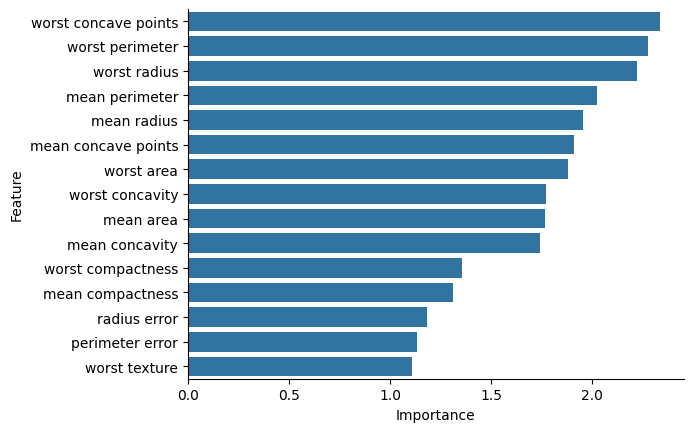

In [7]:
from sklearn.naive_bayes import GaussianNB
import numpy as np

nb = GaussianNB()
nb.fit(X_train, y_train)

mu_0 = nb.theta_[0]
mu_1 = nb.theta_[1]
var_0 = nb.var_[0]
var_1 = nb.var_[1]
denominator = np.sqrt((var_0 + var_1) / 2)
importance = np.abs((mu_1 - mu_0) / denominator)

nb_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance}).sort_values(by='Importance', ascending=False)

sns.barplot(data=nb_df.head(15), x='Importance', y='Feature')
sns.despine()

#### Permutation importance

Permutation importance is a model-agnostic technique that measures feature importance by evaluating the drop in model performance when each feature's values are randomly shuffled. It reflects how much each feature contributes to the model's predictive accuracy on **unseen data**.

It is **performed on test data** (or a validation set) because its goal is to measure how much each feature actually contributes to the model's performance on unseen data.

Why not training data?
If you evaluate feature importance on the training data, you're testing how well the model fits the data it has already seen — which doesn't reflect generalization ability. A feature might look important just because the model overfit to it.

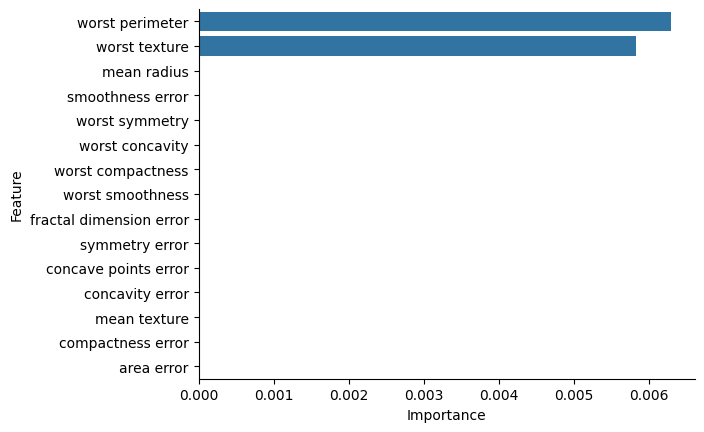

In [8]:
from sklearn.inspection import permutation_importance

# Use a fitted model (e.g., random forest here)
perm = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=42)

perm_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm.importances_mean
}).sort_values(by='Importance', ascending=False)

sns.barplot(data=perm_df.head(15), x='Importance', y='Feature')
sns.despine()

### Explained variance with PCA

Principal Component Analysis (PCA) transforms the data into a new coordinate system where each axis (principal component) captures a portion of the variance in the original features.

#### Explained variance
- Measures how much information (variance) each principal component retains from the original dataset.
- The **explained variance ratio** indicates the fraction of total variance captured by each component.
- The **cumulative explained variance** helps determine how many components are needed to retain most of the original information.

#### Recommendations
- Always scale the data before applying PCA.
- Fit PCA on the **training data only** to avoid data leakage in modeling pipelines.
- Use cumulative explained variance to guide dimensionality reduction (e.g., choose enough components to retain 90–95% of variance).


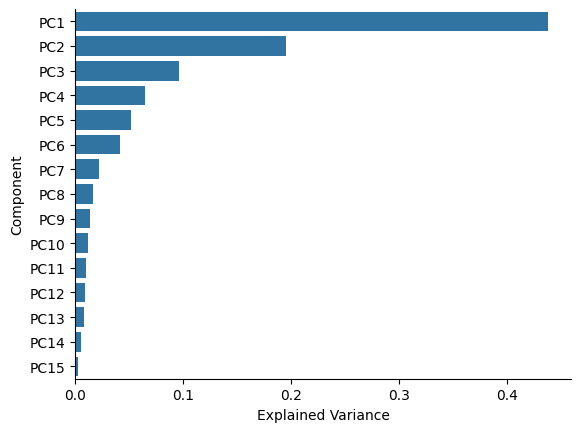

In [9]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train_scaled)

explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

pca_df = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(explained_var))],
    'Explained Variance': explained_var,
    'Cumulative Variance': cumulative_var
})

sns.barplot(data=pca_df.head(15), x='Explained Variance', y='Component')
sns.despine()

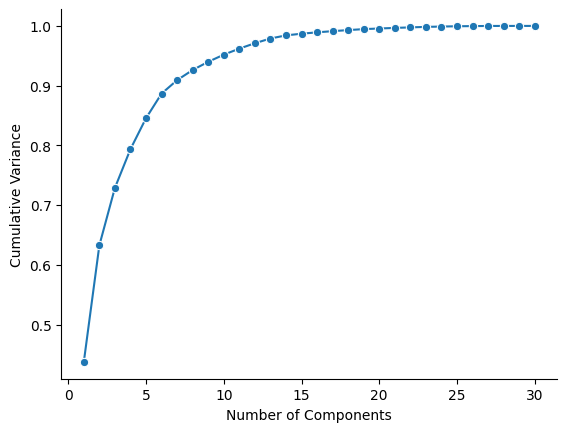

In [10]:
pca_df['Number of Components'] = np.arange(1, len(pca_df) + 1)

sns.lineplot(pca_df, x='Number of Components', y='Cumulative Variance', marker='o')
sns.despine()